
# Unbalanced Classification

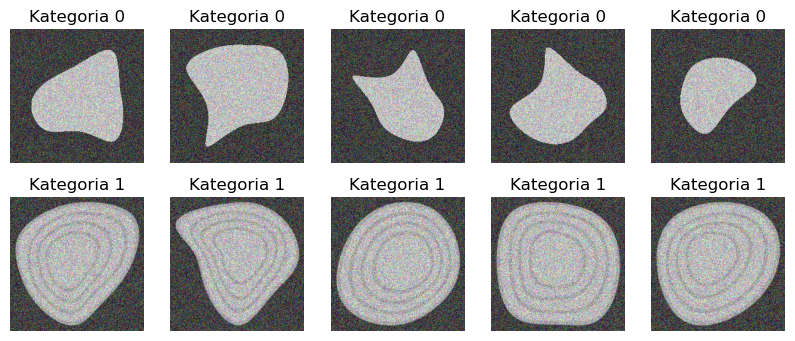

## Introduction

Image classification is the process of assigning a label to an image based on its content. For example, we would like our computer program to be able to recognize whether an image contains a cat, dog, car, airplane, or something else entirely. Nowadays, convolutional neural networks (CNNs) are a popular tool for image recognition.

Convolutional neural networks are a type of neural network that can analyze and recognize patterns in visual data.

In the case of image classification, a convolutional network consists of several layers, including convolutional and pooling layers. Convolutional layers are used to extract features from the image, then we reduce the dimensions of the data using pooling layers, and finally, we use fully connected layers to classify the image.

Progressive reduction of layers allows networks to recognize increasingly abstract features as compositions of many smaller features, e.g., a bird is something that has a beak and is feathered. The beak, in turn, is, for example, a sharp shape of a yellowish color, and the feathers indicate coverage with a large number of small strokes.

### Task

Implement the `YourCnnClassifier` classifier, which recognizes and classifies images into two classes. It should be a convolutional neural network written using the `pytorch` package.

Your data in this task consists of images in \*.jpg format with dimensions of 224 x 224. These images are divided into two categories: *normal* and *onion*, which are respectively labeled 0 and 1.

Images from the *normal* class depict light gray figures on a black background. In contrast, images from the *onion* class differ in that they have added dark gray bands forming layers inside the light gray figures, resembling onions. All images are additionally noisy.

Public interface of the `YourCnnClassifier` class must consist of two methods ([class methods](https://stackoverflow.com/questions/12179271/meaning-of-classmethod-and-staticmethod-for-beginner)):
- `load` - it should load the model parameters from the `cnn-classifier.pth` file. This will be used when testing your solution.
- `create_with_training` - it should train the model and save its parameters to the `cnn-classifier.pth` file.

### Evaluation Criterion

Your solution will be evaluated based on the classification effectiveness

$$
\mathrm{score}(accuracy) = \begin{cases}
    0 & \text{if } accuracy < 0.5 \\
    (accuracy - 0.5) * 2 & \text{otherwise}
\end{cases}
$$

The above criterion, the abstract class describing the model interface, and loading the data are implemented below by us. At the same time, an example of a trivial classifier is provided, which always claims that the sample is normal. Therefore, when testing on a balanced test set, it receives 0 points.

### Submission Files

1. This notebook
2. A file containing the model weights named `cnn-classifier.pth`

**Note:** The training dataset we provide is unbalanced, while your solution will be tested on a balanced set to ensure that the `accuracy` metric is meaningful. Keep this in mind when creating your model.

### Limitations

- Evaluation of your solution (without training, `FINAL_EVALUATION_MODE` flag set to `True`) on 50 test examples should take no longer than 2 minutes on Google Colab **without** GPU.
- Running the script on Google Colab **without** GPU with the `FINAL_EVALUATION_MODE` flag set to `False` should train the model and generate the weight file in no more than 15 minutes.

## Evaluation

Remember that during checking, the `FINAL_EVALUATION_MODE` flag will be set to `True`. Using the `validation_script.py` script, you can ensure that your solution will be properly executed on our evaluation servers.

# Starter Code

In [1]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

FINAL_EVALUATION_MODE = False

# During the evaluation of your solution, we will change this value to True
# The value of this flag M U S T be set to False in the solution you submit to us!


In [2]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

import abc
from typing import Self
import os

import glob
import gdown
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import zipfile

## Loading Data

In [3]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

GDRIVE_DATA = [
    ("1bR87z7ZI3gLK0vAGkyr_cnVGZ9P9bO7A", "train_data.zip"),
    ("1TA0lWnjJCv3lyRMML4JNHsJz3RJ-TUwZ", "valid_data.zip"),
]

def download_data():
    for file_id, zip_name in GDRIVE_DATA:
        folder_name = zip_name.split(".")[0]
        if not os.path.exists(folder_name):
            url = f'https://drive.google.com/uc?id={file_id}'
            gdown.download(url, output=zip_name, quiet=True)
            with zipfile.ZipFile(zip_name, 'r') as zip_ref:
                    zip_ref.extractall(folder_name)
            os.remove(zip_name)

download_data()

class ImageDataset(torch.utils.data.Dataset):
    """Implementation of the abstraction of the dataset in PyTorch."""
    def __init__(self, dataset_type: str):
        self.filelist = glob.glob(f"{dataset_type}_data/*")
        self.labels   = [0 if "normal" in path else 1 for path in self.filelist]

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = torchvision.transforms.functional.to_tensor(plt.imread(self.filelist[idx])[:,:,0])
        label = self.labels[idx]
        return image, label
    
    def loader(self, **kwargs) -> torch.utils.data.DataLoader:
        """
        Create a `DataLoader` for the current dataset.

        All `**kwargs` will be passed to the constructor of `torch.utils.data.DataLoader`.
        `DataLoader`s are an abstraction for loading data that provide a convenient interface.
        You can learn more about them here: [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
        """
        return torch.utils.data.DataLoader(self, **kwargs)
    
train_dataset: ImageDataset = ImageDataset("train")
valid_dataset: ImageDataset = ImageDataset("valid")

## Evaluation Criterion Code

In [4]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

def accuracy_to_points(accuracy: float) -> float:
    """Calculate the score based on the prediction accuracy."""
    return (round(accuracy, 2) - 0.5) * 2 if accuracy > 0.5 else 0.0

def grade(model):
    """Assess how many points the current task will receive."""
    model.eval()
    model

    test_loader = valid_dataset.loader()
    correct = 0
    total = 0
    with torch.no_grad():
        for [images, labels] in test_loader:
            outputs = model(images).squeeze()
            incorrect_indices = torch.where((outputs > 0.5).int() != labels)[0]
            correct += len(labels) - len(incorrect_indices)
            total += len(labels)
        accuracy = correct / total if total != 0 else 0
        if not FINAL_EVALUATION_MODE:
            print(f"Accuracy: {int(round(accuracy, 2) * 100)}%")
        return accuracy_to_points(accuracy)

## Public Interface of the Solution

This is all we require from your class. In your solution, you can modify your class as you wish, adding new methods and class attributes - anything you need to solve the task.

In [5]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

class CnnClassifier(torch.nn.Module, abc.ABC):
    MODEL_PATH: str = "cnn-classifier.pth"
    
    @classmethod
    @abc.abstractmethod
    def load(cls) -> Self:
        """Load the model from a file."""
        
    
    @classmethod
    @abc.abstractmethod
    def create_with_training(cls) -> Self:
        """Save the model to a file."""
        ...

## Sample Solution
Below, we present a simple solution, which is obviously not optimal. It is provided to demonstrate how the entire notebook should work.

In [6]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

if not FINAL_EVALUATION_MODE:
    class DummyCnnClassifier(CnnClassifier):
        def forward(self, x):
            batch_size, *_ = x.shape
            return torch.zeros(batch_size)

        @classmethod
        def load(cls) -> Self:
            return cls()
        
        @classmethod
        def create_with_training(cls) -> Self:
            return cls()
    
    dummy_model = DummyCnnClassifier.create_with_training()
    print(f"DummyCnnClassifier -- Ocena: {grade(dummy_model)} pkt")

    del dummy_model
    del DummyCnnClassifier

Accuracy: 50%
DummyCnnClassifier -- Ocena: 0.0 pkt


# Your Solution

In [7]:
class YourCnnClassifier(CnnClassifier):
    def forward(self, x):
        batch_size, *_ = x.shape
        return torch.zeros(batch_size)

    @classmethod
    def load(cls) -> Self:
        return cls()
    
    @classmethod
    def create_with_training(cls) -> Self:
        return cls()

In [8]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

your_model = YourCnnClassifier.load() if FINAL_EVALUATION_MODE else YourCnnClassifier.create_with_training()

# Evaluation

In [9]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

def evaluate_model(model):
    """Evaluate how many points the current task will receive."""
    return grade(model)

In [10]:
######################### DO NOT MODIFY THIS CELL WHILE SENDING ##########################

if not FINAL_EVALUATION_MODE:
    print(f"YourCnnClassifier -- Ocena: {evaluate_model(your_model):.2f} pkt")

Accuracy: 50%
YourCnnClassifier -- Ocena: 0.00 pkt
